## Prepare your data

For this tutorial you need to download the Stanford Bunny from here:

    https://github.com/alecjacobson/common-3d-test-models/blob/master/data/stanford-bunny.zip

Unzip the file and write the path to the `bun_zipper.ply`-file into the `bunny_path`-variable:

In [1]:
from geoconv.utils.misc import normalize_mesh

import open3d as o3d
import trimesh

# TODO: Enter the path to 'bun_zipper.ply' here!
bunny_path = "/home/andreas/Uni/Projects/geoconv/geoconv/examples/stanford_bunny/bun_zipper.ply"

# Load and normalize the triangle mesh
bunny = o3d.io.read_triangle_mesh(bunny_path)
bunny = bunny.simplify_quadric_decimation(target_number_of_triangles=6000)
bunny = trimesh.Trimesh(vertices=bunny.vertices, faces=bunny.triangles)
normalized_bunny, geodesic_diamter = normalize_mesh(bunny, geodesic_diameter=None)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


100%|███████████████████████████| 3040/3040 [01:06<00:00, 45.77it/s, Calculating geodesic diameter..]

-> Normalized with geodesic diameter: 0.25270776231631265


# Pre-Processing Meshes with GeoConv

The `preprocess_demo.py`-file contains a prototypical pre-processing pipeline regarding meshes and GeoConv.
This pipeline processes the data (triangle meshes) into a format which can be propagated into Intrinsic Mesh CNNs.
Generally speaking, it normalizes the mesh, computes *local Geodesic Polar Coordinate Systems* and afterwards uses those as a means to compute *Barycentric Coordinates*.
In order to understand, why these steps are necessary we need to understand how the Intrinsic Surface Convolution (ISC) is defined, how it is discretized and how GeoConv implements it.

## Intrinsic Surface Convolution

### Theory

Given the theory from [1] and the parametric framework for non-Euclidean convolutions of [2], we can define the *Intrinsic Surface Convolution* (ISC) as:
$$
(s \ast t)_w(\textbf{u}) = \underset{B_{\rho_\text{max}}(\textbf{0})}{\int} t(\textbf{v}) [D_w(\textbf{u})s](\textbf{v}) d\textbf{v}
$$
Thereby, $t(\cdot)$ represents a *template* that contains trainable weights and $[D_w(\textbf{u})s](\cdot)$ the (parametric) *patch operator* [2] that extracts (and interpolates) signal $s(\cdot)$ from the surface.
Figuratively speaking, when computing $(s \ast t)(\textbf{u})$, we can think of "laying" $t(\cdot)$ onto the surface centered in surface point $\textbf{u}$, just as we "lay" a template onto an image when computing (spatial) Euclidean convolutions. Then, with the help of the patch operator, we locally read the surface signal and integrate over the products of weights and read signal values.

The patch operator can be defined as [1, 2]:
$$
[D_w(\textbf{u})s](\textbf{v}) = \underset{B_{\rho_\text{max}}(\textbf{0})}{\int} w_\textbf{v}(\textbf{y})[s \circ \text{exp}_\textbf{u} \circ \omega_\textbf{u}](\textbf{y})\ d\textbf{y}
$$

The patch operator's goal is to *interpolate and extract local surface information*. It considers three components:
- The *signal* $s: M^2 \rightarrow \mathbb{R}$ defined on the surface $M^2$ (in theory, $M^2$ is a two-dimensional compact Riemannian manifold)
- The *prior* $w: \mathbb{R}^2 \times \mathbb{R}^2 \rightarrow \mathbb{R}$ (the nomenclature is not standardized here, the literature refers to those as interpolation coefficients, kernels or weight functions [2, 3])
- The *patch* $[\text{exp}_\textbf{u} \circ \omega_\textbf{u}]: \mathbb{R}^2 \rightarrow M^2$ (local surface area)
    - the exponential map $\text{exp}_\textbf{u}: T_\textbf{u} M^2 \to M^2$ *locally* associates tangent vectors with surface points
    - the frame for the tangent plane (also referred to as *gauge* [1]): $\omega_\textbf{u}: \mathbb{R}^2 \to T_\textbf{u} M^2$ associates coordinates with tangent vectors

#### Rerieving signals from surfaces

The function composition $[s \circ \text{exp}_\textbf{u} \circ \omega_\textbf{u}](\cdot)$ for manifold convolutions has been developed in [1].
We refer to that function as the *signal retrieval function*, or simply *signal retrieval*.
For the Euclidean convolution on images we need to know the relative positions between image pixels.
These are simply given by subtracting the indices (or coordinates) of the pixels.
Analogously, when working with surfaces, we use *tangent vectors* as a local notion for relative positions between surface points, since subtraction for surface points is not defined.
However, tangent vectors are coordinate free in general. 
This is why we are required to define *some* local frame $\omega_\textbf{u}: \mathbb{R}^2 \rightarrow T_\textbf{u} M^2$ that associates coordinates with tangent vectors and whose origin is in surface point $\textbf{u}$.
Be aware that there is no unique frame in general [1].
For example, a chosen frame can be arbitrarly rotated and each rotation yields another frame which adequatly describes local surface information.
This (frame/gauge) ambiguity problem is often times referred to as **angular coordinate ambiguity** [1, 2, 3, 4].

Given a frame $\omega_\textbf{u}$ centered in surface point $\textbf{u}$, we can map the tangent vector $\omega_\textbf{u}(\textbf{y})$ with coordinates $\textbf{y}$ onto a surface point with the exponential map $\text{exp}_\textbf{u}: T_\textbf{u} M^2 \rightarrow M^2$. The exponential map is limited by the so called **injectivity radius** $\rho_\text{max}$. Surface points which lie farther than $\rho_\text{max}$ to the origin will be mapped on coordinates which are already assigned to other surface points.

To sum it up, the patch portrays a local area element of the surface around a center point $\textbf{u}$.
We can access the points within the patch via local coordinates and retrieve their signal values.

### Practice

Since we cannot analytically solve $(s \ast t)(\textbf{u})$ to get a closed form solution, we discretize the integral into a sum in practice.
To this end, we discretize the disc $B_{\rho_\text{max}}(\textbf{0})$ into a finite set of points
$$
\mathbb{T} = \{\rho_r\}_{r=0}^{N_\rho-1} \times \{\theta_a\}_{a=0}^{N_\theta-1} \text{ with } \rho_r = \frac{(r+1)\rho_\text{max}}{N_\rho} \text{ and } \theta_a = \frac{2 a \pi}{N_\theta} \text{ for } r,a \geq 0 \text{ and } \rho_{\text{max}} \in \mathbb{R}^+ \setminus \{0\}
$$

That is, we basically sample points out of the disc and therefore make it finite:

In [2]:
from geoconv.preprocessing.barycentric_coordinates import create_template_matrix
from matplotlib import pyplot as plt

import ipywidgets as widgets

@widgets.interact(N_rho=(0, 10), N_theta=(0, 20), rho_max=(0.1, 2.))
def f(N_rho=5, N_theta=8, rho_max=1.):
    template_vertices = create_template_matrix(n_radial=N_rho, n_angular=N_theta, radius=rho_max, in_cart=False)
    fig = plt.figure()
    ax = fig.add_subplot(projection='polar')
    ax.scatter(template_vertices.reshape(-1, 2)[:, 1], template_vertices.reshape(-1, 2)[:, 0])

interactive(children=(IntSlider(value=5, description='N_rho', max=10), IntSlider(value=8, description='N_theta…

This discretization of the integration domain leaves us with the *discrete ISC*:
$$
(s \ast t)_w(\textbf{u}) = \underset{\textbf{t}_{ra} \in \mathbb{T}}{\sum} t(\textbf{t}_{ra}) [D_w(\textbf{u})s](\textbf{t}_{ra})
$$
Thereby holds that $\textbf{t}_{ra} = (\rho_r, \theta_a)$. Instead of defining a continuous template $t(\cdot)$, the discrete ISC defines weights only at coordinates $\textbf{t}_{ra}$.
Hence, we refer to the set $\mathbb{T}$ as *discrete template* and to its points $\textbf{t}_{ra} \in \mathbb{T}$ as *template vertices* (blue dots in the above plot).

Returning to our previous "visual intuition":
In contrast to the theoretical ISC the discrete ISC only lays a finite amount of template vertices onto the surface.
Surface points which *are not* located directly beneath our template vertices become redundant and are no longer considered during the discrete ISC.
Those surface points that *are* located directly beneath the template vertices are used to extract and interpolate the surface signal.

In practice, we can approximate surfaces with triangle meshes.
Triangle meshes consist of a set of vertices $\mathbb{V}$ and a set of faces $\mathbb{F}$.
Faces are vertex-index-triples.
Those triples represent connections through edges between vertices, creating triangles.
Hence, instead of lying on a continuous surface, our template vertices now lie in between the mesh vertices on triangles.
However, in practice the signal function is typically only defined on the mesh vertices, i.e. $s: \mathbb{V} \to \mathbb{R}$.

Thus, a very central question for the discrete ISC in practice is how we implement signal retrieval on triangle meshes.
Or more generally asking, *how do we discretize the patch operator?*

Since the patch operator also considers an integral over $B_{\rho_{\text{max}}}(\textbf{0})$, the most evident adjustment is to adopt the discretized template into the patch operator:
$$
[D_w(\textbf{u})s](\textbf{v}) = \underset{\textbf{t}_{ra} \in \mathbb{T}}{\sum} w_\textbf{v}(\textbf{t}_{ra})[s \circ \text{exp}_\textbf{u} \circ \omega_\textbf{u}](\textbf{t}_{ra})
$$

Now we are left with the definition of the prior $w_\textbf{v}(\textbf{t}_{ra})$ and the implementation of the signal retrieval $[s \circ \text{exp}_\textbf{u} \circ \omega_\textbf{u}](\textbf{t}_{ra})$ at template vertices $\textbf{t}_{ra}$ on triangle meshes.
We will first focus on signal retrieval.

#### Rerieving signals from triangle meshes 

In essence, the template vertices $\textbf{t}_{ra}$ specify positions within the patch $[\text{exp}_\textbf{u} \circ \omega_\textbf{u}](\cdot)$ around mesh vertex $\textbf{u}$ at which we want to retrieve signal values $s(\cdot)$. 
[5] suggests to compute $[s \circ \text{exp}_\textbf{u} \circ \omega_\textbf{u}](\textbf{t}_{ra})$ by computing **barycentric coordinates** for the vertices of the triangle in which $\textbf{t}_{ra}$ fell.

However, the mesh vertices $\mathbb{V}$ are given in *global* 3D-coordinates.
This poses a problem because we cannot interpolate the template vertices $\mathbb{T}$, which are given in *local* 2D-polar-coordinates, with global 3D-coordinates.

Given vertex $\textbf{u}$, on which we "lay" the center of $\mathbb{T}$, how can we retrieve the neighboring mesh vertices $\textbf{v}$ of $\textbf{u}$ with 2D-polar-coordinates? 
*That is, how do we determine the polar-coordinates $(\rho, \theta)$ for $\textbf{v} = [\text{exp}_\textbf{u} \circ \omega_\textbf{u}](\rho, \theta)$*?
To this end, [5] adopts the idea of [3] and calculates local **Geodesic Polar Coordinate Systems** (**GPC-systems**), which represent the sets of all geodesic-polar-coordinates for neighboring vertices $\textbf{v}$ of center vertex $\textbf{u}$ in a radius $\rho_{\text{max}}$.

##### Computing GPC-systems with GeoConv

There exist different ways for computing GPC-systems [3, 6].
GeoConv provides an implementation of the algorithm from [6] (`compute_gpc_systems`).
From the theory we know that we must consider the following two aspects to avoid computing degenerated GPC-systems:
1. **Injectivity Radius**: The injectivity radius is the maximal extension of a local GPC-system
2. **Angular Coordinate Ambiguity**: The angular coordinate ambiguity refers to the ambiguity in the selection of a reference direction within a local GPC-system. That is, it addresses the question "Where is 0° in our GPC-system?".

While the functions provided by GeoConv take care of defining a reference direction, you still need to think about what maximal radius your GPC-systems are allowed to have. Here are two "rules" that you should consider when elaborating on that question:
1. The maximal radius should not be **smaller** than the **largest** one-hop neighborhood distance of the vertices from your normalized mesh
2. The maximal radius should not be **larger** than the **smallest** injectivity radius of your normalized meshes

In practice, we use the following rule of thumb:
- Let the largest one-hop neighborhood distance in your dataset of **all** meshes be given by $r$
- Set the maximal radius for **all** GPC-systems to: $R = r * \alpha$ for $\alpha > 1$

While definetly not being a perfect choice, this ensures that you will not violate the first rule. However, be aware that you might get degenerate GPC-systems in meshes at places where $R$ exceeds the injectivity radius.

The following code-box calculates multiple GPC-systems of different size for a single origin. Configure `vertex_idx`, `amt_alphas` and `largest_alpha` yourself.
- `vertex_idx`: Determines the origin of the local coordinate system on the mesh
- `amt_alphas`: Determines how many alpha are computed
- `largest_alpha`: Determines the size of the largest GPC-system

In [3]:
from geoconv.utils.misc import find_largest_one_hop_dist
from geoconv.preprocessing.discrete_gpc import local_gpc
from geoconv.utils.visualization import draw_gpc_on_mesh, draw_gpc_triangles

import matplotlib
import numpy as np
import os

# Configure here! #
vertex_idx = 500  #
amt_alphas = 20   #
largest_alpha = 2.#
###################

# Create directory for images
image_dir = f"{os.path.dirname(bunny_path)}/gpc_images"
if not os.path.exists(image_dir):
    os.makedirs(image_dir)

r = find_largest_one_hop_dist(normalized_bunny)
all_alphas = np.linspace(1., largest_alpha, amt_alphas)
for idx, alpha in enumerate(all_alphas):
    # Calculate GPC-system radius
    R = r * alpha

    # Calculate one GPC-system
    radial_coordinates, angular_coordinates, _ = local_gpc(vertex_idx, R, normalized_bunny, use_c=True)

    # Visualization
    draw_gpc_on_mesh(
        vertex_idx,
        radial_coordinates,
        angular_coordinates,
        normalized_bunny,
        save_name=f"{image_dir}/bunny_gpc_system_{idx}",
        angles=(0., 0., 0.),  # Camera setting
        distance=.9,  # Camera setting
        center=(0., 0., 0.)  # Camera setting
    )
    draw_gpc_triangles(
        normalized_bunny,
        vertex_idx,
        u_max=R,
        print_scatter=False,
        plot=False,
        title="GPC-system in 2D",
        save_name=f"{image_dir}/2d_gpc_system_{idx}.png"
    )

100%|██████| 3040/3040 [00:03<00:00, 819.78it/s, Determining largest one-hop neighborhood distance..]


**Check your results** with the following code-box. In the top row you see the GPC-systems illustrated directly on the Stanford Bunny in the 3-dimensional space.
- The *red* colors indicate the *radial* distance from the origin (darker means larger)
- The *green* colors indicate the *angular* distance from the reference direction (darker means larger)

In the lower row you see *the same* GPC-system but in 2D. Ihe moment the blue appears darker, you overstepped the injectivity radius. We generally try to avoid that case.

In [4]:
from geoconv.examples.stanford_bunny.preprocess_tutorial.tutorial_widgets import check_gpc_systems

import ipywidgets as widgets

@widgets.interact(alpha=(0, amt_alphas - 1))
def f(alpha=0):
    check_gpc_systems(image_dir, all_alphas, alpha)

interactive(children=(IntSlider(value=0, description='alpha', max=19), Output()), _dom_classes=('widget-intera…

In practice, we need a GPC-system for every vertex. In orther words, each vertex once has to be the origin of a GPC-system. Conveniently, GeoConv equips you with a wrapper function that does exactly that (`compute_gpc_systems`).

In [5]:
from geoconv.preprocessing.discrete_gpc import compute_gpc_systems

from pathlib import Path

alpha = 1.1
R = r * alpha
bunny_path_gpc = f"{os.path.dirname(bunny_path)}/bunny_gpc_systems.npy"
if not Path(bunny_path_gpc).is_file():
    gpc_systems = compute_gpc_systems(normalized_bunny, u_max=R, tqdm_msg="Computing GPC-systems", use_c=True)
    np.save(bunny_path_gpc, gpc_systems)
else:
    gpc_systems = np.load(bunny_path_gpc)

print(f"Result shape of GPC-system array: {gpc_systems.shape}")
print(f"That is, we have {gpc_systems.shape[0]} GPC-systems in total, for our mesh that has {gpc_systems.shape[1]} vertices.")

100%|█████████████████████████████████████| 3040/3040 [00:59<00:00, 51.32it/s, Computing GPC-systems]


Result shape of GPC-system array: (3040, 3040, 2)
That is, we have 3040 GPC-systems in total, for our mesh that has 3040 vertices.


Here, the `gpc_systems` contains all GPC-systems. It always follows the following structure:
1. Dimension: `gpc_systems[i]` returns the GPC-system centered in vertex $\textbf{v}_i$ of the underlying triangle mesh (in short: $i$-th GPC-system)
2. Dimension: `gpc_systems[i, j]` returns the geodesic coordinates of the $j$-th vertex of the mesh in the $i$-th GPC-system. Note that vertices that are not included in the GPC-system default to have $[\infty\ -1]$ as geodesic polar coordinates
3. Dimension: `gpc_systems[i, j, 0]` returns a radial coorodinate (geodesic distance); `gpc_systems[i, j, 1]` returns an angular coordinate

We can now lay our discretized template $\mathbb{T}$ onto the triangle mesh by laying it into a GPC-system:

In [6]:
from geoconv.examples.stanford_bunny.preprocess_tutorial.tutorial_widgets import summary_visualization

import ipywidgets as widgets

@widgets.interact(vertex_idx=(0, normalized_bunny.vertices.shape[0] - 1), N_rho=(0, 10), N_theta=(0, 20), alpha=(0.1, 2.))
def f(vertex_idx=0, N_rho=5, N_theta=8, alpha=1.):
    summary_visualization(normalized_bunny, idx, r, vertex_idx, N_rho, N_theta, alpha)

interactive(children=(IntSlider(value=0, description='vertex_idx', max=3039), IntSlider(value=5, description='…

##### Computing barycentric coordinates

Within a GPC-system we can interpolate signal values $s(\cdot)$ beneath the template vertices $\textbf{t}_{ra}$. That is, we can calculate:

$$
[s \circ \text{exp}_{\textbf{u}} \circ \omega_{\textbf{u}}](\textbf{t}_{ra})
$$

To this end, we follow the approach of [5] and calculate [barycentric coordinates](https://en.wikipedia.org/wiki/Barycentric_coordinate_system#Barycentric_coordinates_on_triangles).

GeoConv's `compute_gpc_systems`-function returns a tensor $\textbf{G}$ that contains all GPC-systems for a triangle mesh.
Let $\textbf{G}_k$ represent the $k$-th GPC-system.
For the discrete ISC in vertex $\textbf{v}_k$ we "lay" the discretized template $\mathbb{T}$ into GPC-system $\textbf{G}_k$:

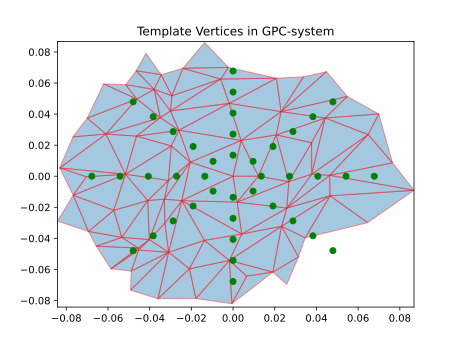

In [7]:
from IPython.display import SVG, display
display(SVG("./figures/template_in_gpc_system.svg"))

Now we can compute $[s \circ \text{exp}_{\textbf{v}_k} \circ \omega_{\textbf{v}_k}](\textbf{t}_{ra})$ for all template vertices $\textbf{t}_{ra} \in \mathbb{T}$ with the help of GPC-system $\textbf{G}_k$.
For example, choose this $\textbf{t}_{ra}$:

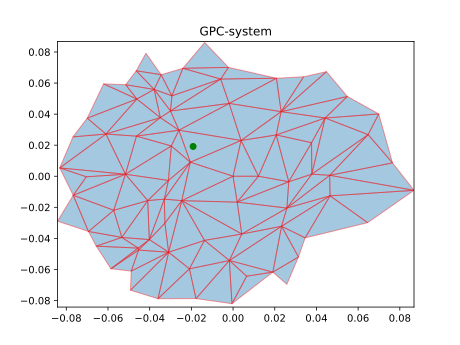

In [8]:
from IPython.display import SVG, display
display(SVG("./figures/one_tvertex_in_gpc_system.svg"))

We can clearly see, that $\textbf{t}_{ra}$ lies within a triangle:

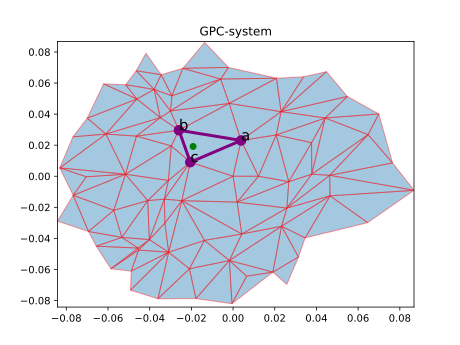

In [9]:
from IPython.display import SVG, display
display(SVG("./figures/triangle_in_gpc_system.svg"))

The coordinates of highlighted mesh vertices in the $k$-th GPC-system can be read from $\textbf{G}_k$:
- $\textbf{G}_{ka} = \textbf{v}_a$
- $\textbf{G}_{kb} = \textbf{v}_b$
- $\textbf{G}_{kc} = \textbf{v}_c$

We can describe $\textbf{t}_{ra}$ as a linear combination of the triangle vertices $\{\textbf{G}_{ka}, \textbf{G}_{kb}, \textbf{G}_{kc}\}$. Thereby, the coefficients of the linear combination are the barycentric coordinates $\{\beta_{ka}, \beta_{kb}, \beta_{kc}\}$ of the triangle vertices for $\textbf{t}_{ra}$. 
In total we thus have:

$$
\textbf{t}_{xy} = 
\beta_{ka} \textbf{G}_{ka} +
\beta_{kb} \textbf{G}_{kb} +
\beta_{kc} \textbf{G}_{kc}
$$

GeoConv provides a function which is called `compute_barycentric_coordinates`.
This function computes barycentric coordinates for all template vertices in all GPC-systems:

In [10]:
from geoconv.preprocessing.barycentric_coordinates import compute_barycentric_coordinates

n_radial = 5
n_angular = 8
alpha = 1.1
bunny_path_bc = f"{os.path.dirname(bunny_path)}/bunny_barycentric_coordinates.npy"
R = r * alpha
template_radius = R * 0.75
if not Path(bunny_path_bc).is_file():
    barycentric_coordinates = compute_barycentric_coordinates(
        normalized_bunny, gpc_systems, n_radial=n_radial, n_angular=n_angular, radius=template_radius, verbose=True
    )
    np.save(bunny_path_bc, barycentric_coordinates)
else:
    barycentric_coordinates = np.load(bunny_path_bc)

print(f"Result shape of barycentric coordinate tensor: {barycentric_coordinates.shape}\n")
r_a = (1, 2)
print(f"The barycentric coordinates for template vertex {r_a}")
gpc_system_idx = 0
print(f"... when the template has been layed into GPC-system {gpc_system_idx}")
print(f"... are: {barycentric_coordinates[gpc_system_idx, r_a[0], r_a[1], :, 1]}")
print(f"... the associated vertex indices: {barycentric_coordinates[gpc_system_idx, r_a[0], r_a[1], :, 0]}")

100%|█████████████████████████| 3040/3040 [00:51<00:00, 59.03it/s, Computing barycentric coordinates]

Result shape of barycentric coordinate tensor: (3040, 5, 8, 3, 2)

The barycentric coordinates for template vertex (1, 2)
... when the template has been layed into GPC-system 0
... are: [0.14351454 0.39414281 0.46234265]
... the associated vertex indices: [202.   1. 237.]


Here, the `barycentric_coordinates` represents the tensor that contains all barycentric coordinates.
It always follows the following structure:
- 1 Dimension: `barycentric_coordinates[k]` contains all barycentric coordinates for the template, when it was laid on mesh vertex $\textbf{v}_k$
- 2 and 3. Dimension: `barycentric_coordinates[k, r, a]` contains the barycentric coordinates and associated mesh vertex indices for template vertex $(\rho_r, \theta_a)$
- 4 Dimension: `barycentric_coordinates[k, r, a, i]` contains the $i$-th barycentric coordinate and the associated mesh vertex index for template vertex $(\rho_r, \theta_a) \in \mathbb{T}$
- 5 Dimension: `barycentric_coordinates[k, r, a, i, 1]` contains the barycentric coordinate for the mesh vertex with index that is stored in `barycentric_coordinates[k, r, a, i, 0]`

> *<ins>Side-Note</ins>: In GeoConv, template vertices which do not fall into any triangle of the GPC-system receive barycentric coordinates $\beta_i = 0$ for $i=1,2,3$.*

Let $s: \mathbb{V} \rightarrow \mathbb{R}^n$ be an $n$-dimensional signal defined on the mesh vertices $\mathbb{V}$.
We can define signal $s(\cdot)$ as a *signal matrix* $\textbf{S} \in \mathbb{R}^{|\mathbb{V}| \times n}$ with $\textbf{S}_z = s(\textbf{G}_{kz}) = s(\textbf{v}_z)$.
Given the barycentric coordinates tensor $\textbf{B}$, we can locally retrieve the mesh signal beneath template vertex $\textbf{t}_{ra}$ by interpolating the signal values of the surrounding triangle vertices with pre-computed barycentric coordinates:
$$
[s \circ \text{exp}_{\textbf{v}_k} \circ \omega_{\textbf{v}_k}](\textbf{t}_{ra}) = \sum_{i=0}^2 \textbf{B}_{krai1} \textbf{S}_{\textbf{B}_{kxyi0}}
$$

With the computation of the barycentric coordinates we have finished the pre-processing part for our data.
However, inserting the signal retrieval into our discretized patch operator:

$$
[D_w(\textbf{v}_k)s](\textbf{t}_{xy}) = \underset{\textbf{t}_{ra} \in \mathbb{T}}{\sum} w_{\textbf{t}_{xy}}(\textbf{t}_{ra})[s \circ \text{exp}_{\textbf{v}_k} \circ \omega_{\textbf{v}_k}](\textbf{t}_{ra}) = \underset{\textbf{t}_{ra} \in \mathbb{T}}{\sum} w_{\textbf{t}_{xy}}(\textbf{t}_{ra}) \sum_{i=0}^2 \textbf{B}_{krai1} \textbf{S}_{\textbf{B}_{krai0}}
$$

raises the question about how we configure the *prior* $w_\bullet(\cdot)$.
The prior configuration is a network-design-question and has nothing to do with pre-processing our data.
In the remaining tutorial, we want to address this issue and derive the entire discretized inrinsic surface convolution, which GeoConv implements.

##### Prior configuration

The prior defines a function $w: \mathbb{R}^2 \times \mathbb{R}^2 \to \mathbb{R}$.
The value $w_{\textbf{v}}(\textbf{w})$ modulates how much neighbor vertex $\textbf{w}$ contributes to the signal value at $\textbf{v}$.
The selection of $w$ is up to the network-designer.
For example, Geodesic- [3] and anisotropic convolutional neural networks [4] use Gaussians [2].
GeoConv, however, also implements the exponential-, $\mathcal{X}^2$, student-t- and Dirac-distribution priors.

In GeoConv, we can easily implement new intrinsic surface convolutional layers. For this, we sub-class `ConvIntrinsic` and specifying how their priors looks like, by implementing `define_interpolation_coefficients`.
For this, one needs to define a four-dimensional tensor $\textbf{W}$ that follows the following structure:
- $\textbf{W} \in \mathbb{R}^{N_{\rho} \times N_{\theta} \times N_{\rho} \times N_{\theta}}$ specifies all weight matrices. That is, one weight matrix per template vertex $\textbf{t}_{xy}$
- $\textbf{W}_{xy} \in \mathbb{R}^{N_{\rho} \times N_{\theta}}$ specifies a weight matrix for all template vertices $\textbf{t}_{ra}$, while the prior is centered in $\textbf{t}_{xy}$

GeoConv also offers the possibility to visualize the prior.
For example, we can visualize the prior of geodesic IMCNNs:

In [14]:
from geoconv.layers.angular_max_pooling import AngularMaxPooling
from geoconv.layers.conv_geodesic import ConvGeodesic
from geoconv.utils.visualization import draw_prior

from tensorflow import keras


def define_model():
    signal_input = keras.layers.Input(shape=(3,), name="signal")
    bc_input = keras.layers.Input(shape=(5, 8, 3, 2), name="bc")
    output = ConvGeodesic(
        output_dim=1,
        amt_kernel=1,
        kernel_radius=0.028,
        activation="relu",
        name="gc",
        splits=5
    )([signal_input, bc_input])
    model = keras.Model(inputs=[signal_input, bc_input], outputs=[output])
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=["sparse_categorical_accuracy"], run_eagerly=True)
    return model

intrinsic_mesh_cnn = define_model()
W = intrinsic_mesh_cnn.layers[2]._kernel_vertices

# TODO: Fix coloring
@widgets.interact(x=(0, W.shape[0] - 1), y=(0, W.shape[1] - 1))
def f(x=0, y=0):
    draw_prior(intrinsic_mesh_cnn.layers[2], indices=[(x, y)]) 

interactive(children=(IntSlider(value=0, description='x', max=4), IntSlider(value=0, description='y', max=7), …

Including $\textbf{W}$ into the patch operator yields the discretized patch operator:

$$
[D_\textbf{W}(\textbf{v}_k)\textbf{S}](\textbf{t}_{xy}) = \underset{\textbf{t}_{ra} \in \mathbb{T}}{\sum} W_{xyra} \sum_{i=0}^2 \textbf{B}_{krai1} \textbf{S}_{\textbf{B}_{krai0}}
$$

## The Discretized Intrinsic Surface Convolution

Including the discretized patch operator into the definition for the discrete ISC yields:
$$
(\textbf{S} \ast t)_\textbf{W}(\textbf{v}_k) = \underset{\textbf{t}_{ra} \in \mathbb{T}}{\sum} t(\textbf{t}_{ra}) [D_\textbf{W}(\textbf{v}_k)\textbf{S}](\textbf{t}_{ra})
$$
We are left to define how $t(\cdot)$ looks like in practice.
Given an $n$-dimensional signal $\textbf{S} \in \mathbb{R}^{|\mathbb{V}| \times n}$, the discretized patch operator returns a vector:
$$
[D_\textbf{W}(\textbf{v}_k)\textbf{S}](\textbf{t}_{xy}) \in \mathbb{R}^n
$$
We associate a *trainable weight matrix* $\textbf{T}_{ra} \in \mathbb{R}^{m \times n}$ with each template vertex $\textbf{t}_{ra}$.
Due to this, we transform the $n$-dimensional signal at each $\textbf{t}_{ra}$ into an $m$-dimensional signal, causing the final value at $\textbf{v}_k$ also to be $m$-dimesnional.
In total we thus learn a four-dimensional tensor $\textbf{T} \in \mathbb{R}^{N_{\rho} \times N_{\rho} \times m \times n}$.
We define the discrete ISC in triangle mesh vertex $\textbf{v}_k$ with prior $\textbf{W}$ between signal $\textbf{S}$ and template $\textbf{T}$ as:
$$
(\textbf{S} \ast \textbf{T})_\textbf{W}(\textbf{v}_k) = \underset{\textbf{t}_{ra} \in \mathbb{T}}{\sum} \textbf{T}_{ra} [D_\textbf{W}(\textbf{v}_k)\textbf{S}](\textbf{t}_{ra}) = \underset{\textbf{t}_{ra} \in \mathbb{T}}{\sum} \textbf{T}_{ra} \underset{\textbf{t}_{xy} \in \mathbb{T}}{\sum} W_{raxy} \sum_{i=0}^2 \textbf{B}_{kxyi1} \textbf{S}_{\textbf{B}_{kxyi0}}
$$
Eventually, we apply an activation function on the result:
$$
(\textbf{S} \ast \textbf{T})_{\textbf{W}}(\textbf{v}_k) = \Phi \left( \underset{\textbf{t}_{ra} \in \mathbb{T}}{\sum} \textbf{T}_{ra} [D_\textbf{W}(\textbf{v}_k)\textbf{S}](\textbf{t}_{ra}) \right)
$$
GeoConv's `ConvIntrinsic` class implements that function in its core.
However, in practice, we can extend this definition into considering $P$ templates per layer, as suggested in [3].
We incorporate this idea into `ConvIntrinsic`, hence computing:
$$
(\textbf{S} \ast \textbf{T})_{\textbf{W}, P}(\textbf{v}_k) = \underset{p=0}{\sum^{P-1}} \Phi \left( \underset{\textbf{t}_{ra} \in \mathbb{T}}{\sum} \textbf{T}^{(p)}_{ra} [D_\textbf{W}(\textbf{v}_k)\textbf{S}](\textbf{t}_{ra}) \right)
$$

## Rotating Surface Information and Angular Max-Pooling

Due to angular coordinate ambiguity, [3] suggests to compute the ISC for multiple relative orientations between the extracted signal and the template.
Subsequently, [3] selects the maximum result over all rotations.
That process is referred to as *angular max-pooling* (AMP) [1, 2, 3, 4, 5].
In order to realize AMP, GeoConv's `ConvIntrinsic`-class rotates the retrieved signal at the template vertices while remaining a fixed template orientation:
$$
(\textbf{S} \ast \textbf{T})_{\textbf{W}, P, \Delta a}(\textbf{v}_k) = \underset{p=0}{\sum^{P-1}} \Phi \left( \underset{\textbf{t}_{ra} \in \mathbb{T}}{\sum} \textbf{T}^{(p)}_{ra} [D_\textbf{W}(\textbf{v}_k)\textbf{S}](\textbf{t}_{r((a+\Delta a) \text{ mod } N_{\theta})}) \right)
$$
That is, the final result of any ISC-layer in GeoConv are $N_{\theta}$ convolutions:
$$
(\textbf{S} \ast \textbf{T})_{\textbf{W}, P}(\textbf{v}_k) = \left\{(\textbf{S} \ast \textbf{T})_{\textbf{W}, P, \Delta a}(\textbf{v}_k)\ |\ \Delta a \in \{0, ..., N_{\theta} - 1\}\right\}
$$
Every discrete ISC layer in GeoConv returns a three-dimensional tensor:

In [16]:
# Load our pre-processed data
bunny_barycentric = np.load(f"{os.path.dirname(bunny_path)}/bunny_barycentric_coordinates.npy")
bunny = trimesh.load_mesh(f"{os.path.dirname(bunny_path)}/bun_zipper.ply")
bunny_signal = np.array(bunny.vertices)

# Propagate it into our IMCNN
output = intrinsic_mesh_cnn([bunny_signal, bunny_barycentric])
print(f"Output shape of our IMCNN when propagating our pre-processed data into it: {output.shape}")

Output shape of our IMCNN when propagating our pre-processed data into it: (3040, 8, 1)


Thereby, the output tensor follows the following structure:
1. Dimension: `output[i]` returns the convolution results for mesh vertex $\textbf{v}_i$ for all rotations
2. Dimension: `output[i, j]` returns the convolution result for the $j$-th rotation for mesh vertex $\textbf{v}_i$
3. Dimension: `output[i, j, k]` returns the $k$-the entry in the result vector of the convolution result for the $j$-th rotation for mesh vertex $\textbf{v}_i$

AMP itself is defined as a separate layer.
It takes the result of an ISC-layer as input and returns the vector with the largest Euclidean norm.
That is:
$$
\text{AMP} \left( (\textbf{S} \ast \textbf{T})_{\textbf{W}, P}(\textbf{v}_k) \right) = \underset{(\textbf{S} \ast \textbf{T})_{\textbf{W}, P, \Delta a}(\textbf{v}_k) \in (\textbf{S} \ast \textbf{T})_{\textbf{W}, P}(\textbf{v}_k)}{\text{arg\,max}} || (\textbf{S} \ast \textbf{T})_{\textbf{W}, P, \Delta a}(\textbf{v}_k) ||_2
$$

# Summary

In this tutorial, we have discussed the theoretical ISC and theoretical patch operator, aswell as their components.
We have presented a possible approach on how to discretize the ISC and the patch operator.
Thereby we have focused on the computation of local GPC-systems on triangle meshes aswell as how we can use them to compute barycentric coordinates for signal retrieval.
Subsequently, we have shortly covered the topic of priors and how we can configure them in GeoConv.
Lastly, we have elaborated on AMP and its implementation in GeoConv.
For all required steps, we have shown how we can use GeoConv not only to calculate the required values, but also to visualize the intermediate results.

Since we now came to the end of this tutorial, we want to provide a short example that can be used as a starting point for experiments:

In [12]:
from geoconv.utils.misc import normalize_mesh, find_largest_one_hop_dist
from geoconv.preprocessing.discrete_gpc import compute_gpc_systems
from geoconv.preprocessing.barycentric_coordinates import compute_barycentric_coordinates

from pathlib import Path


# 1. Normalize your meshes.
normalized_bunny, _ = normalize_mesh(bunny, geodesic_diameter=geodesic_diamter)

# 2. Define a signal on your mesh vertices. If unsure, simply use the normalized 3D-coordinates.
mesh_signal = normalized_bunny.vertices

# 3. Compute GPC-systems.
alpha = 1.1
R = find_largest_one_hop_dist(normalized_bunny) * alpha
bunny_path_gpc = f"{os.path.dirname(bunny_path)}/bunny_gpc_systems.npy"
if not Path(bunny_path_gpc).is_file():
    gpc_systems = compute_gpc_systems(normalized_bunny, u_max=R, tqdm_msg="Computing GPC-systems", use_c=True)
    np.save(bunny_path_gpc, gpc_systems)
else:
    gpc_systems = np.load(bunny_path_gpc)

# 4. Compute barycentric coordinates.
bunny_path_bc = f"{os.path.dirname(bunny_path)}/bunny_barycentric_coordinates.npy"
n_radial = 5
n_angular = 8
template_radius = R * 0.75
if not Path(bunny_path_bc).is_file():
    barycentric_coordinates = compute_barycentric_coordinates(
        normalized_bunny, gpc_systems, n_radial=n_radial, n_angular=n_angular, radius=template_radius, verbose=True
    )
    np.save(bunny_path_bc, barycentric_coordinates)
else:
    barycentric_coordinates = np.load(bunny_path_bc)

# => [mesh_signal, barycentric_coordinates] will be required by Intrinsic Mesh CNNs!

-> Normalized with geodesic diameter: 0.25270776231631265


100%|██████| 3040/3040 [00:03<00:00, 826.13it/s, Determining largest one-hop neighborhood distance..]


Thank you for showing interest in GeoConv!

# Sources

[1] Bronstein, Michael M., et al. "Geometric deep learning: Grids, groups, graphs, geodesics, and gauges." arXiv preprint arXiv:2104.13478 (2021).

[2] Monti, Federico, et al. "Geometric deep learning on graphs and manifolds using mixture model cnns." Proceedings of the IEEE conference on computer vision and pattern recognition. 2017.

[3] Masci, Jonathan, et al. "Geodesic convolutional neural networks on riemannian manifolds." Proceedings of the IEEE international conference on computer vision workshops. 2015.

[4] Boscaini, Davide, et al. "Learning shape correspondence with anisotropic convolutional neural networks." Advances in neural information processing systems 29 (2016).

[5] Poulenard, Adrien, and Maks Ovsjanikov. "Multi-directional geodesic neural networks via equivariant convolution." ACM Transactions on Graphics (TOG) 37.6 (2018): 1-14.

[6] Melvær, Eivind Lyche, and Martin Reimers. "Geodesic polar coordinates on polygonal meshes." Computer Graphics Forum. Vol. 31. No. 8. Oxford, UK: Blackwell Publishing Ltd, 2012.